In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Qiskit imports
from qiskit.circuit import QuantumCircuit, ParameterVector
from qiskit.circuit.library import zz_feature_map, real_amplitudes
from qiskit_ibm_runtime import EstimatorV2 as Estimator

%load_ext autoreload
%autoreload 2

## Import Data

In [23]:
# Load data with pandas
data = pd.read_csv("diabetes_normalized.csv")
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,-0.923998,1.531329,0.566517,-0.920265,-3.141593,0.004682,-1.668720,-0.104720,1
1,-2.771994,-0.457820,0.257508,-1.301064,-3.141593,-0.650792,-2.409180,-2.094395,-1
2,-0.184800,2.636412,0.154505,-3.141593,-3.141593,-0.959801,-1.547992,-1.989675,1
3,-2.771994,-0.331525,0.257508,-1.681863,-2.443461,-0.510333,-2.902821,-3.141593,-1
4,-3.141593,1.184017,-1.081532,-0.920265,-1.893868,0.894254,2.787459,-1.884956,1


### Train-Test Split

In [24]:
from sklearn.model_selection import train_test_split

In [25]:
x, y = data.drop(["Outcome"], axis=1), data["Outcome"]
nfeatures = x.shape[1]

In [46]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(537, 8) (537,) (231, 8) (231,)


In [47]:
x_train = np.asarray(x_train)
y_train = np.asarray(y_train)

## Building the Variational Quantum Classifier (VQC) for Binary Classification Problem

This will include multiple steps, starting with 

A. Building the VQC algorithm 
1. Data Embedding, followed by,
2. Parameterized Quantum Circuit (PQC)/Ansatz with trainable parameters.

B. Optimizing the circuit and operators
1. Setting up Qiskit Runtime Service
2. Traspilation

C. Execution and Results
1. Setup Primitives 

D. Post-processing
1. Visualizing the results

### Step A1: Data Embedding

In [9]:
from utils import angle_embedding

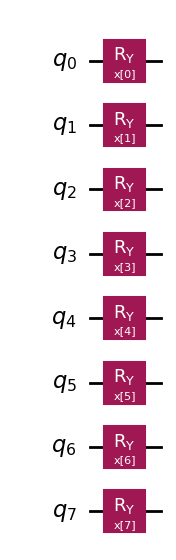

In [10]:
feature_params = ParameterVector('x', nfeatures)
embedding = angle_embedding(nfeatures, feature_params)
embedding.draw("mpl")

### Step A2: PQC with Trainable Parameters

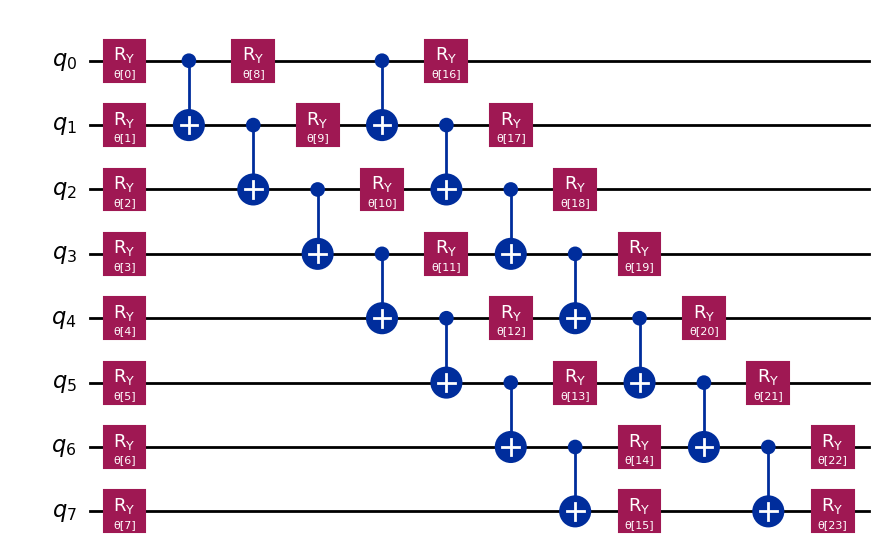

In [11]:
ansatz = real_amplitudes(nfeatures, entanglement="linear", reps=2)
ansatz.draw("mpl")

In [12]:
weight_params = ansatz.parameters
weight_params

ParameterView([ParameterVectorElement(θ[0]), ParameterVectorElement(θ[1]), ParameterVectorElement(θ[2]), ParameterVectorElement(θ[3]), ParameterVectorElement(θ[4]), ParameterVectorElement(θ[5]), ParameterVectorElement(θ[6]), ParameterVectorElement(θ[7]), ParameterVectorElement(θ[8]), ParameterVectorElement(θ[9]), ParameterVectorElement(θ[10]), ParameterVectorElement(θ[11]), ParameterVectorElement(θ[12]), ParameterVectorElement(θ[13]), ParameterVectorElement(θ[14]), ParameterVectorElement(θ[15]), ParameterVectorElement(θ[16]), ParameterVectorElement(θ[17]), ParameterVectorElement(θ[18]), ParameterVectorElement(θ[19]), ParameterVectorElement(θ[20]), ParameterVectorElement(θ[21]), ParameterVectorElement(θ[22]), ParameterVectorElement(θ[23])])

### Final VQC Circuit

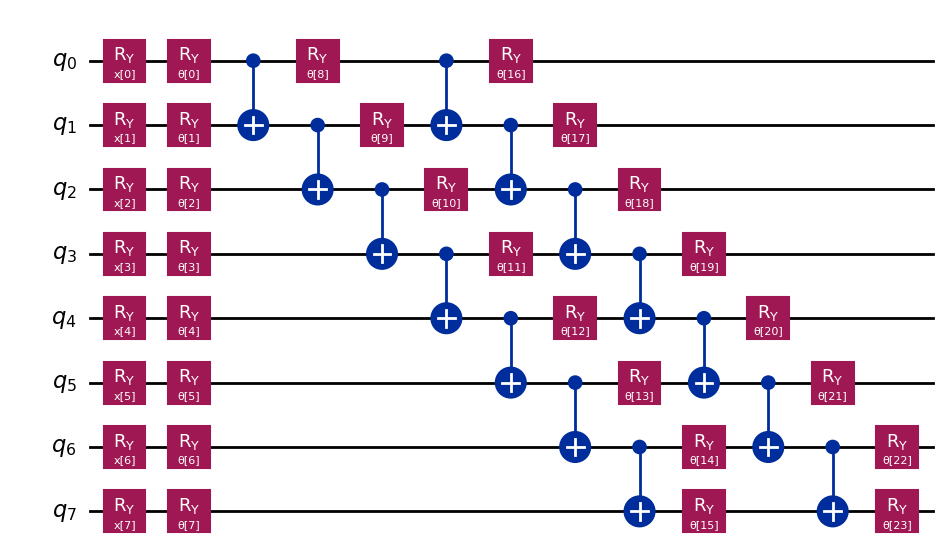

In [13]:
vqc_circuit = embedding.compose(ansatz, qubits=range(nfeatures))
vqc_circuit.draw("mpl")

In [14]:
# Setting up circuit observables
from qiskit.quantum_info import SparsePauliOp

observable = SparsePauliOp(["IIIIIIIZ"]) 

## Step B: Optimize circuits and operators

### Step B1: Setup Qiskit Runtime Service

In [15]:
# Setup Qiskit Runtime
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime.fake_provider import FakeQuebec

# If setting up Qiskit Runtime for the first time with custom hub/group/instance
# QiskitRuntimeService.save_account(channel="ibm_quantum", token="token", instance="hub/group/project", name="CustomName")
# service = QiskitRuntimeService(instance="hub/group/project")

service = QiskitRuntimeService(instance="ibm-q/open/main")
# backend = service.least_busy(simulator=False, operational=True)
fake_backend = FakeQuebec()

### Step B2: Transpilation

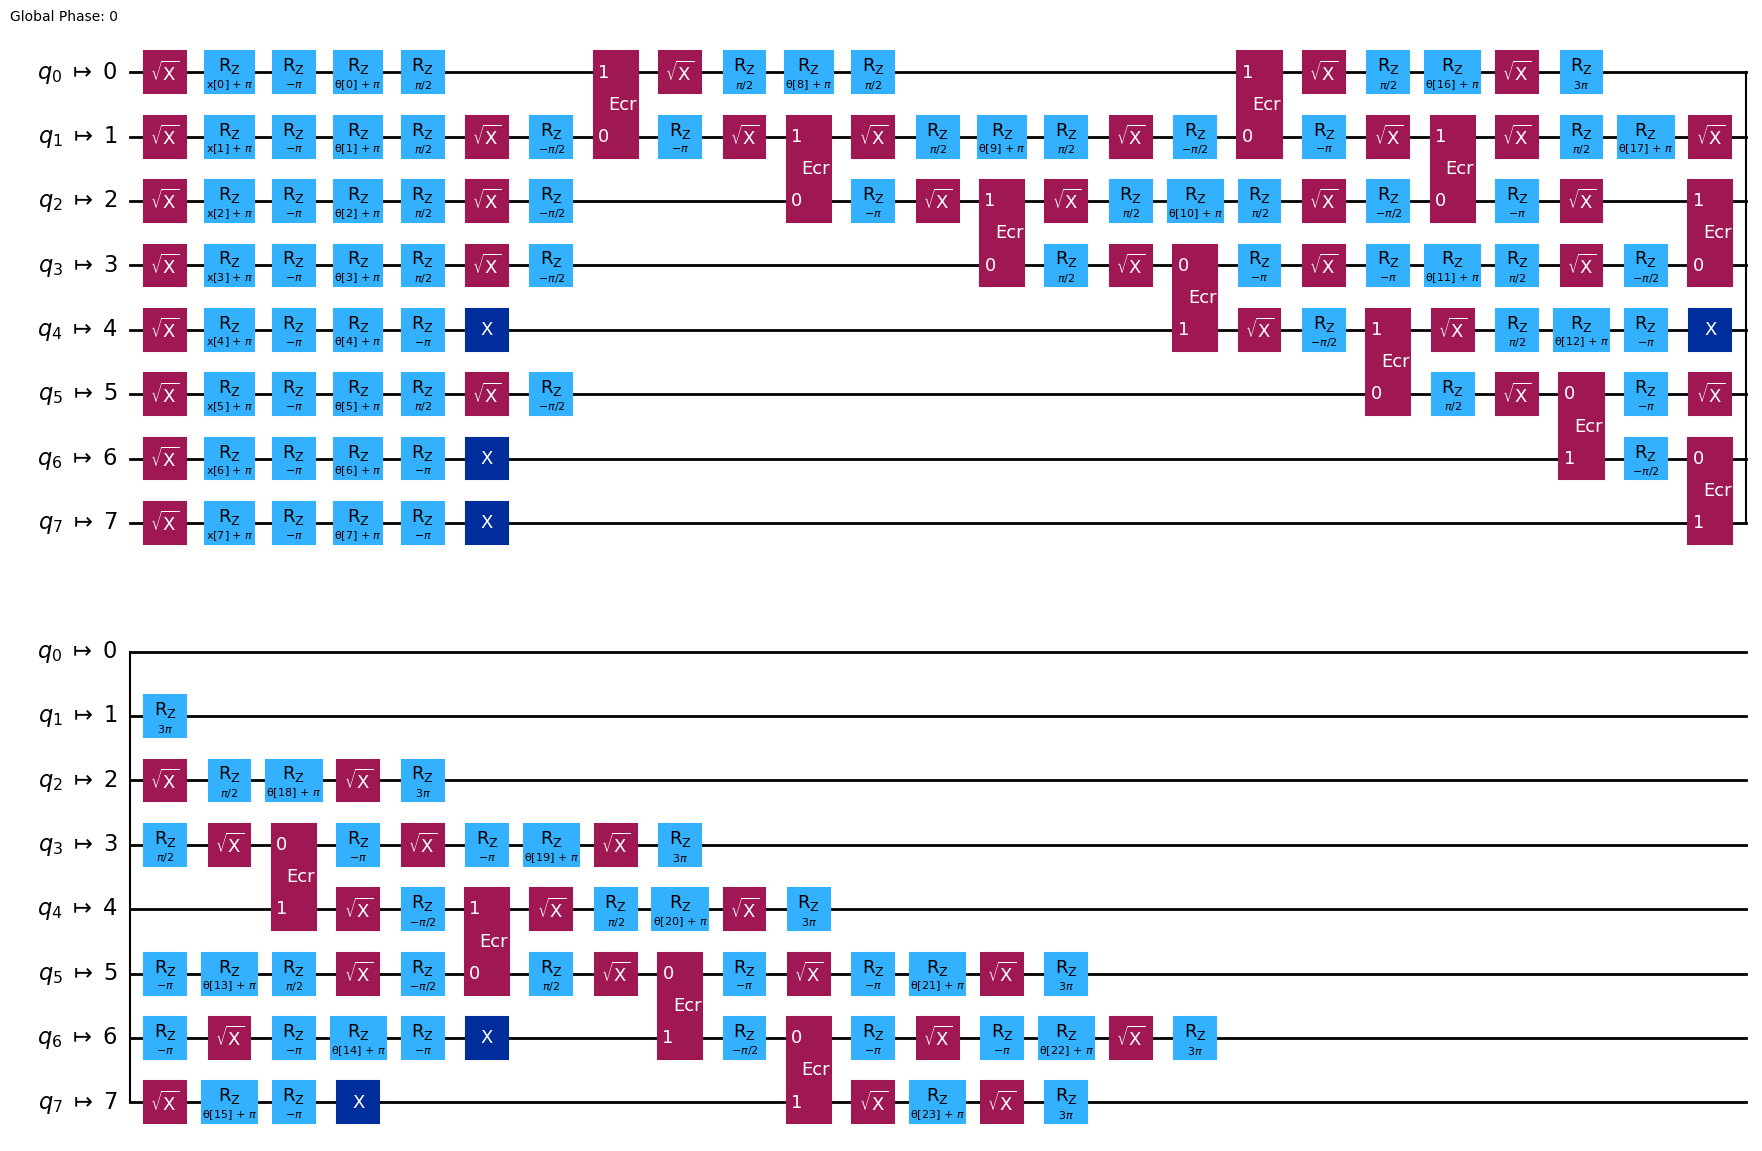

In [16]:
# Build an ISA circuit using pre-set transpilation passes.
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

pm = generate_preset_pass_manager(backend=fake_backend, optimization_level=1)    # You can change the optimization level
vqc_transpiled_circuit = pm.run(vqc_circuit)
vqc_transpiled_circuit.draw("mpl", idle_wires=False)

In [17]:
# Apply obervables to the transpiled layout
mapped_observables = [obs.apply_layout(vqc_transpiled_circuit.layout) for obs in observable]
mapped_observables

[SparsePauliOp(['IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZ'],
               coeffs=[1.+0.j])]

## Step C: Execution and Results

### Step C1: Setup Primitives

In [32]:
# Imports
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit_machine_learning.optimizers import COBYLA

In [22]:
# Estimator Primitive
estimator = Estimator(mode=fake_backend)

# Define the QNN Primitive
estimator_qnn = EstimatorQNN(
    estimator=estimator,
    circuit=vqc_circuit,
    observables=mapped_observables,
    input_params=feature_params.params,
    weight_params=weight_params,
    pass_manager=pm,
)

In [63]:
from IPython.display import clear_output

# Callback function
def callback_graph(weights, objective_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(objective_func_eval)
    print(f"COBYLA Epoch {len(objective_func_vals)}: {objective_func_eval:.5f}")
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [64]:
VQC = NeuralNetworkClassifier(
    neural_network=estimator_qnn, 
    optimizer=COBYLA(maxiter=60), 
    callback=callback_graph,
)

COBYLA Epoch 60: 0.67814


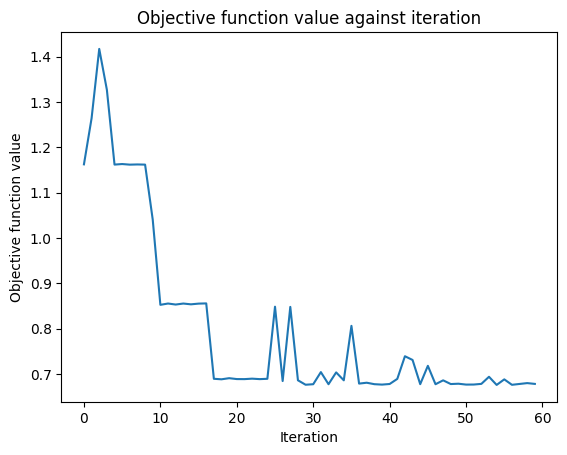

NameError: name 'X' is not defined

In [65]:
objective_func_vals = []
VQC.fit(x_train, y_train)

In [67]:
# Train Score
score_train = VQC.score(x_train, y_train)
print(f'Score on the train set {score_train}')

# Test Score
score_test = VQC.score(x_test, y_test)
print(f'Score on the test set {score_test}')

Score on the train set 0.750465549348231
Score on the test set 0.7316017316017316


## Step D: Post-processing and Visualizing the results

In [ ]:
y_test_pred = VQC.predict(x_test)

# Add a column for Test_Label
pairplot_data['Test_Label'] = y_test
# Predicted Label
pairplot_data["Predicted_Label"] = y_test_pred

# print(pairplot_data.head())

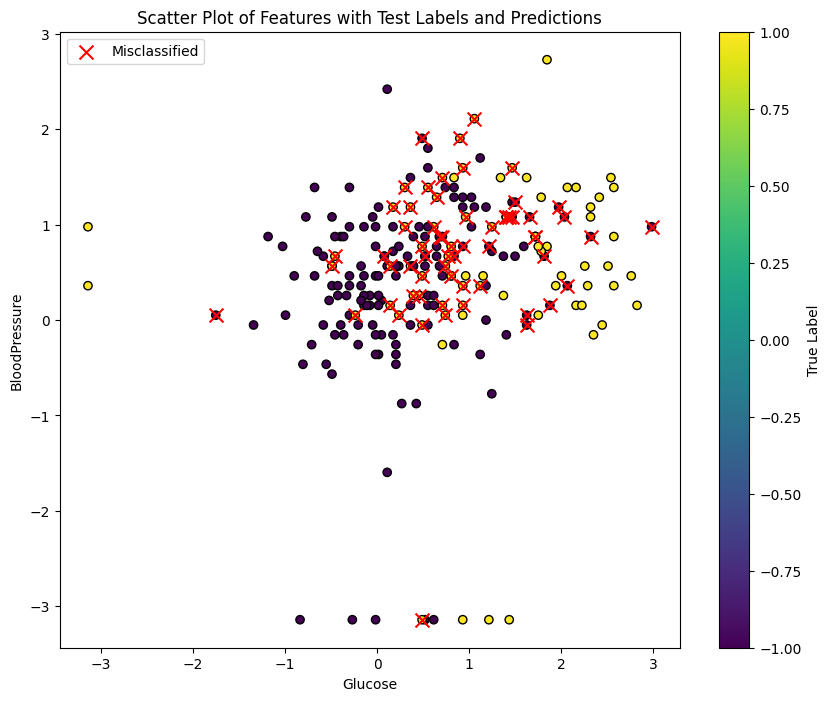

In [81]:
plt.figure(figsize=(10, 8))
scatter = plt.scatter(pairplot_data['Glucose'], pairplot_data['BloodPressure'], c=pairplot_data['Test_Label'], marker='o', edgecolors='k')

# Highlight misclassifications with a different marker
misclassified = pairplot_data[pairplot_data['Test_Label'] != pairplot_data['Predicted_Label']]
plt.scatter(misclassified['Glucose'], misclassified['BloodPressure'], marker='x', s=100, color='red', label='Misclassified')

# Customize the plot
plt.xlabel('Glucose')
plt.ylabel('BloodPressure')
plt.title('Scatter Plot of Features with Test Labels and Predictions')
plt.legend()
plt.colorbar(scatter, label='True Label')

# Show the plot
plt.show()